# Weather Forecasting System

## Importing Libraries

In [12]:
import numpy as np
import pandas as pd

#for visualizations
import seaborn as sn
import matplotlib.pyplot as plt


## Reading the Dataset

In [13]:
data=pd.read_csv('weather_data_test.csv', parse_dates=['datetime'], sep=';', decimal=',', infer_datetime_format=True)

In [14]:
print(data.shape)

(1346, 17)


## Exploring the Data 

In [18]:
df = data[["datetime", "T_mu"]]
df.shape

(1346, 2)

In [19]:
df.head()

,datetime,T_mu
0,2015-09-03,13.7375
1,2015-09-04,14.8250
2,2015-09-05,14.2750
3,2015-09-06,13.1250
4,2015-09-07,12.0875


In [20]:
#selecting the subset 
mask=(df['datetime'] >= '2016-01-01') & (df['datetime'] <= '2019-05-21')
df=df.loc[mask]

#reset the index
df.set_index("datetime", inplace=True)

In [21]:
from IPython.display import display
display(df.head())
display(df.tail())

,T_mu
datetime,
2016-01-01,-4.5500
2016-01-02,-7.0000
2016-01-03,-8.7375
2016-01-04,-11.1750
2016-01-05,-17.6250


,T_mu
datetime,
2019-05-17,13.783333
2019-05-18,15.508333
2019-05-19,16.595833
2019-05-20,17.258333
2019-05-21,18.433333


In [22]:
df.describe()

,T_mu
count,1228.000000
mean,6.302811
std,8.433225
min,-22.675000
25%,0.559375
50%,5.227083
75%,13.784375
max,26.145833


In [26]:
#maximum temperature date
print("maximum temperature: ")
print(df.loc[df["T_mu"]==df["T_mu"].max()])

#minimum temperature date
print("\nminimum temperature: ")
print(df.loc[df["T_mu"]==df["T_mu"].min()])

maximum temperature: 
                 T_mu
datetime             
2018-07-17  26.145833

minimum temperature: 
              T_mu
datetime          
2016-01-07 -22.675


## Visualiazations

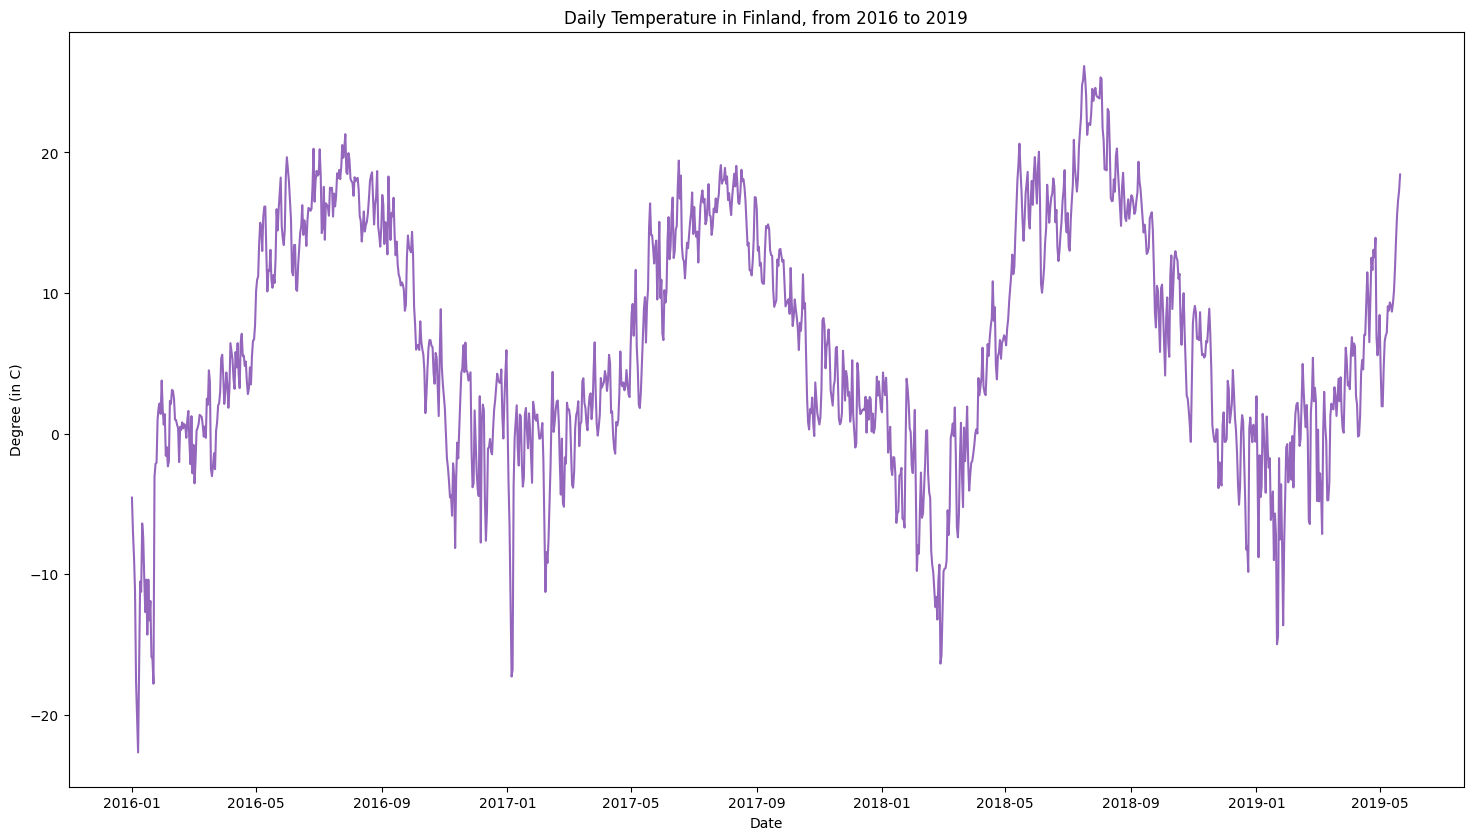

In [28]:
#daily temperature change
plt.figure(figsize=(18,10), dpi=100)
plt.plot(df.index, df.T_mu, color='tab:purple')
plt.gca().set(title="Daily Temperature in Finland, from 2016 to 2019", xlabel='Date', ylabel="Degree (in C)")

plt.show()

[Text(0.5, 1.0, 'Average Temperature in Finland (monthly)'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Degree (in C)')]

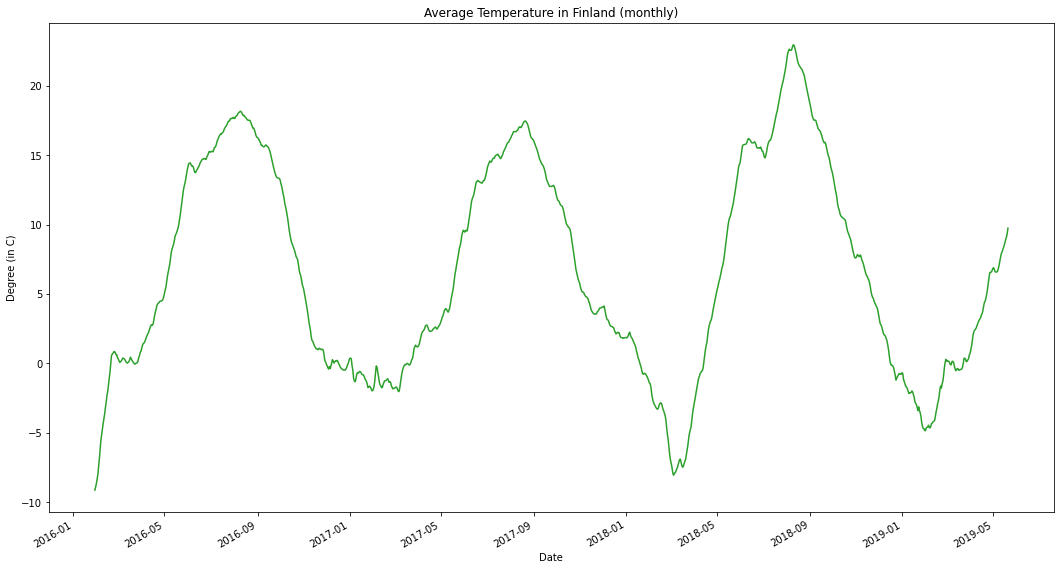

In [33]:
#moving average function by subset of month
df_mean=df.T_mu.rolling(window=30).mean()
df_mean.plot(figsize=(18,10), color='tab:green')

plt.gca().set(title="Average Temperature in Finland (monthly)", xlabel='Date', ylabel="Degree (in C)")


### Using time-series decomposition method:

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

#additive decomposition
result_add=seasonal_decompose(df.T_mu, model='additive', extrapolate_trend='freq', freq=365)


<ipython-input-37-5c0a61d638ab>:4: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



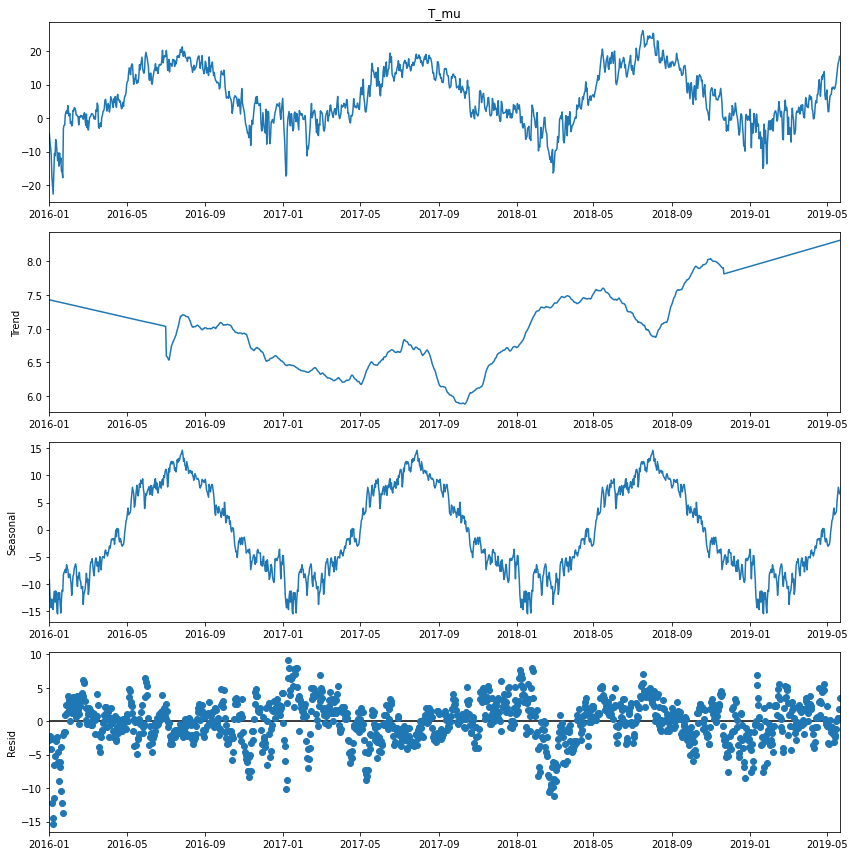

In [42]:
plt.rcParams.update({'figure.figsize': (12,12)})
result_add.plot()

plt.show()

# Baseline model

Assuming that the air temperature today depends on air temperature yesterday, and so on.

Using 1-step prediction to model the temperature as a time series

In [43]:
#shifting current temperature to next day
predicted_df=df["T_mu"].to_frame().shift(1).rename(columns={"T_mu":"T_mu_pred"})
actual_df=df["T_mu"].to_frame().rename(columns={"T_mu":"T_mu_actual"})

#concatenating actual & predicted temperatures
one_step_df=pd.concat([actual_df, predicted_df], axis=1)

one_step_df=one_step_df[1:]
one_step_df.head()

,T_mu_actual,T_mu_pred
datetime,,
2016-01-02,-7.0000,-4.5500
2016-01-03,-8.7375,-7.0000
2016-01-04,-11.1750,-8.7375
2016-01-05,-17.6250,-11.1750
2016-01-06,-20.2625,-17.6250


In [47]:
#validating the model using root mean squared error
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

temp_pred_err=MSE(one_step_df.T_mu_actual,one_step_df.T_mu_pred, squared=False)
print("RMSE: ", temp_pred_err)

RMSE:  2.2618558244607696


## Forecasting using SARIMA model

**SARIMA: Seasonal Autoregressive Integrated Moving Average**

It takes 3 parameters- p, d, q (seasonabilty, trend, noise)

Using grid search to iteratuvely explore different combinations of parameters

In [48]:
import itertools

In [49]:
p=d=q=range(0, 2)

#generating different combinations
pdq=list(itertools.product(p,d,q))

seasonal_pdq=[(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print("Parameter combinations for Seasonal ARIMA: ")
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [50]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual, order=param, seasonal_order=param_seasonal, enforce_stationary=False, enforce_invertibility=False)
            
            results=mod.fit()
            print('SARIMA{}x{}12 -AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

### Model fitting

In [54]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual, order=(1,1,1), seasonal_order=(1,1,1,12),
                             enforce_stationarity=False, enforce_invertibility=False)

results=model.fit()

c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\user\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



**Diagnostics**

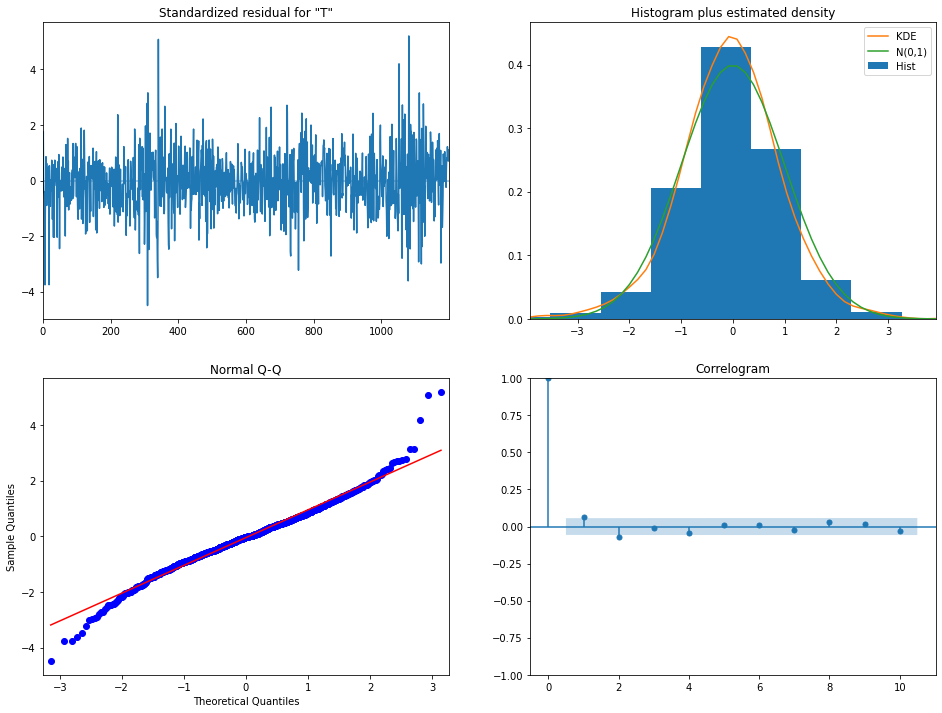

In [55]:
results.plot_diagnostics(figsize=(16,12))
plt.show()

### validating non-dynamic forecast

In [56]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=False)
pred_ci = pred.conf_int()

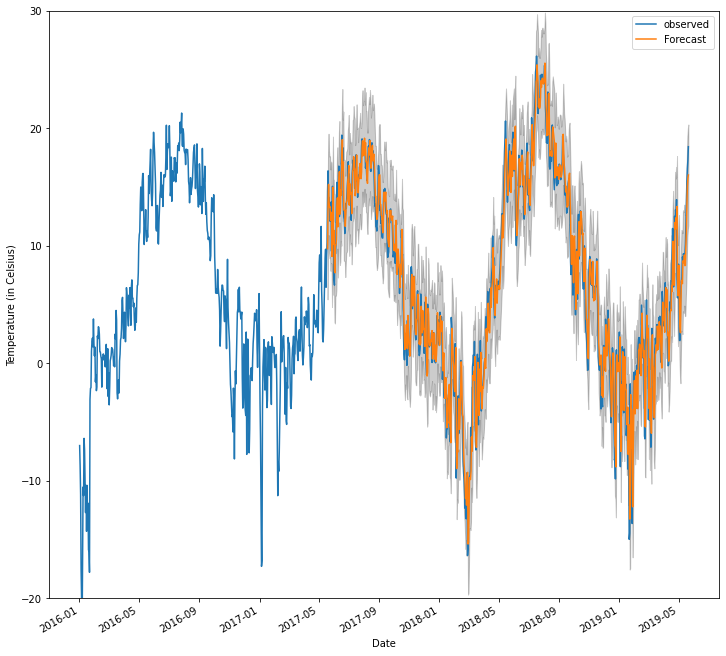

In [57]:
#plotting real and forecasted values
ax = one_step_df.T_mu_actual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

### Forecast diagnostic

In [59]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-05-19':]

print(y_forecasted.shape)
print(y_truth.shape)

#mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error is {}'.format(round(mse, 2)))

(727,)
(727,)
The Mean Squared Error is 4.78
